<a href="https://colab.research.google.com/github/SiegfriedZhen/ptt-analysis/blob/master/ptt_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# install packages
#!pip install pyLDAvis
#!pip install -U ckiptagger[tfgpu,gdown]

#import pyLDAvis#所需可视化模块
#import pyLDAvis.sklearn
# loading your Google drive
from google.colab import drive
import pandas as pd

import jieba
import jieba.analyse
#from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

import gc
import os
import time
import requests
from bs4 import BeautifulSoup

In [0]:
#The default version of TensorFlow in Colab will soon switch to TensorFlow 2.x.
#We recommend you upgrade now or ensure your notebook will continue to use TensorFlow 1.x via the %tensorflow_version 1.x magic: more info.

#https://www.tensorflow.org/guide/migrate
#https://colab.research.google.com/notebooks/tensorflow_version.ipynb

https://github.com/crownpku/Awesome-Chinese-NLP

#Tasks:
##1. find pos/neg samples
##2. feature engineering
#### (1) networking
#### (2) statistics 
##3. modeling
#### (1) scikit
#### (2) cat-boost
ref:  public opinion sys in acnia http://learn.iis.sinica.edu.tw:9187/


In [19]:
drive.mount('/content/drive/', force_remount=True)
path = '/content/drive/My Drive/side project/20191109_ptt_analysis/'
os.listdir(path)

Mounted at /content/drive/


['text_clustering.ipynb',
 'bert_for_ptt.ipynb',
 'ptt_setence_embedding.ipynb',
 'ptt_ana2.ipynb',
 'OCF_project_ptt_gossip_etl_20191023.ipynb',
 'ptt_etl.ipynb',
 'LDA_viz.ipynb',
 'HatePolitics-0-4062.json']

In [0]:
#for root, subdirs, files in os.walk('./'):
#    print(root, subdirs, files)

In [0]:
ht_file = path + 'HatePolitics-0-4062.json'
hate_df = pd.read_json(ht_file, encoding='utf8')

In [22]:
hate_df.shape

(78942, 1)

In [0]:
def ptt_json_to_df(ptt_df):
  art_df = []
  invalid_lst = []
  for x in ptt_df.itertuples():
    #some inconsistent page failed!
    if x.articles == {'error': 'invalid url'}:
        print('invalid record')
        print(x.Index)
        invalid_lst.append(x)
        continue
    art = pd.DataFrame([x.articles])  
    ##如果發文沒有人推或作者是None，直接濾除
    if art.messages[0] == []:
        invalid_lst.append(x)
        continue
    elif art.author[0] is None:
        print('invalid author')
        #print(x.articles)
        invalid_lst.append(x)
        continue
    
    art.author = art.author.replace(r'\([^)]*\)', '',regex=True).values[0].replace(' ', '')
    #fixing package typo of columns
    art.rename({'message_conut':'message_count'}, axis=1, inplace=True)
    reply_aggr = pd.DataFrame(art.message_count.values[0], index=[0])
    art.drop(['message_count'], axis=1, inplace=True)
    art = pd.concat([art, reply_aggr], axis=1)
    art_df.append(art)
  return art_df

In [24]:
hate_df_t1 = ptt_json_to_df(hate_df)
hate_df_t2 = pd.concat(hate_df_t1)

invalid record
8210
invalid record
9353
invalid record
21871
invalid record
21890
invalid record
21898
invalid record
21908
invalid record
21918
invalid record
21935
invalid record
21939
invalid record
22832
invalid record
22856
invalid record
22898
invalid record
22924
invalid record
23519
invalid record
23525
invalid record
23533
invalid record
28836
invalid record
34594
invalid record
34595
invalid record
34596
invalid record
34597
invalid record
34598
invalid record
34599
invalid record
34600
invalid record
34601
invalid record
34602
invalid record
34603
invalid record
34604
invalid record
34605
invalid record
34606
invalid record
34607
invalid record
34608
invalid record
34609
invalid record
34610
invalid author
invalid author
invalid author
invalid record
57989
invalid record
57990
invalid record
57991
invalid record
57992
invalid author


# time formate transform

In [0]:
#what if no time formate

hate_df_t2.date = pd.to_datetime(hate_df_t2.date, format='%a %b %d %H:%M:%S %Y', errors='coerce')
hate_df_t2['re_flag'] = hate_df_t2.article_title.str.contains('Re')

In [26]:
print(hate_df_t2.date.min())
print(hate_df_t2.date.max())

2006-04-03 23:54:45
2019-10-18 08:10:04


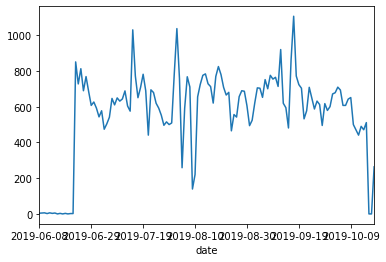

In [30]:
_t = hate_df_t2.date.astype(str).str[:10]
#4 month
_t.groupby(_t).count()[-130:].plot()

In [31]:
_t.groupby(_t).count()[-120:]
#2019-06-23 ~ 10-15

date
2019-06-19      4
2019-06-20      1
2019-06-21      3
2019-06-22      3
2019-06-23    850
             ... 
2019-10-14    471
2019-10-15    511
2019-10-16      1
2019-10-18      1
NaT           264
Name: date, Length: 120, dtype: int64

In [0]:
art_df = hate_df_t2

art_cnt = art_df.groupby('author', as_index=False)['article_id'].count()
author_attr = art_df.groupby('author', as_index=False)['all', 'boo', 'count', 'neutral', 'push'].sum()
author_attr = author_attr.merge(art_cnt, how='left', on='author').rename({'article_id':'art_cnt'}, axis=1)
author_attr.rename({'author':'Id'}, axis=1, inplace=True)

In [0]:
url = 'https://pttpedia.fandom.com/zh/wiki/%E5%88%86%E9%A1%9E:PTT%E5%90%8D%E4%BA%BA'
rs = requests.get(url)
soup = BeautifulSoup(rs.content)

In [0]:
known_id = []

for x in soup.select('.category-page__member-link'):
    #print(x)
    temp_id = x.text.replace(' ', '').split('(')[0].split('（')[0]
    known_id.append(temp_id)
    print(temp_id)

In [66]:
author_attr.sort_values('push', ascending=False)[:20]

,Id,all,boo,count,neutral,push,art_cnt
985,Wojnarowski,41339,5709,10046,19875,15755,348
2881,kero2377,34441,1873,9923,20772,11796,467
3476,nicholas0406,24728,2847,5127,13907,7974,438
2455,hithaman,10534,197,7324,2816,7521,122
667,Neptunium,15330,597,6736,7400,7333,635
3570,omanorboyo,20583,1970,5087,11556,7057,415
4749,wizardfizban,18826,1036,5539,11215,6575,212
1992,ebsd,18328,2936,3164,9292,6100,303
1428,ben108472,18059,1773,4269,10244,6042,338
2276,girl10319,14891,1500,4282,7609,5782,259


In [64]:
author_attr.sort_values('push', ascending=False)[:20].Id.isin(known_id)

985     False
2881    False
3476    False
2455    False
667     False
3570    False
4749    False
1992    False
1428    False
2276    False
4982    False
4916    False
495      True
839     False
3868    False
2553    False
4741    False
3444    False
1901    False
0       False
Name: Id, dtype: bool

# reply

In [35]:
hate_df_t2[:3]

,article_id,article_title,author,board,content,date,ip,messages,all,boo,count,neutral,push,re_flag
0,M.1571141315.A.A38,[新聞] 台灣民眾黨第二波提名 移民署專員陳允萍,batt0909,HatePolitics,1.新聞網址 https://tinyurl.com/y59nj5jl 2.新聞來源 聯合 ...,2019-10-15 20:08:31,118.171.54.225,"[{'push_content': '不是台東人 不過 聽過他的事蹟 很棒', 'push_...",11,0,9,2,9,False
0,M.1565594449.A.3F0,,,HatePolitics,作者: kero2377 (賤畜福利熊) 看板: HatePolitics 標題: [討論]...,NaT,123.194.10.195,"[{'push_content': '我只看見郭台銘蓄勢以待', 'push_ipdatet...",189,11,64,103,75,False
0,M.1570175294.A.C5E,[公告] 政治黑特板板規_20191004_V5.4,mark2165,HatePolitics,第一章 總則 1.本板接受中華民國政府頒布之法律，教育部學術網路公約，以及PTT站方制定之站...,2019-10-04 15:48:12,111.242.230.238,"[{'push_content': '修了什麼也講一下吧', 'push_ipdatetim...",5,0,2,3,2,False


# statistics

In [32]:
hate_df_t2

,article_id,article_title,author,board,content,date,ip,messages,all,boo,count,neutral,push,re_flag
0,M.1571141315.A.A38,[新聞] 台灣民眾黨第二波提名 移民署專員陳允萍,batt0909,HatePolitics,1.新聞網址 https://tinyurl.com/y59nj5jl 2.新聞來源 聯合 ...,2019-10-15 20:08:31,118.171.54.225,"[{'push_content': '不是台東人 不過 聽過他的事蹟 很棒', 'push_...",11,0,9,2,9,False
0,M.1565594449.A.3F0,,,HatePolitics,作者: kero2377 (賤畜福利熊) 看板: HatePolitics 標題: [討論]...,NaT,123.194.10.195,"[{'push_content': '我只看見郭台銘蓄勢以待', 'push_ipdatet...",189,11,64,103,75,False
0,M.1570175294.A.C5E,[公告] 政治黑特板板規_20191004_V5.4,mark2165,HatePolitics,第一章 總則 1.本板接受中華民國政府頒布之法律，教育部學術網路公約，以及PTT站方制定之站...,2019-10-04 15:48:12,111.242.230.238,"[{'push_content': '修了什麼也講一下吧', 'push_ipdatetim...",5,0,2,3,2,False
0,M.1570254569.A.D42,[討論] 政黑投票結果整理,kero2377,HatePolitics,總統你錯了投票結果 投票結果:(共有 228 人投票每人最多可投 5 票) 選 項 政治鬥爭...,2019-10-05 13:49:26,123.194.10.195,"[{'push_content': '厚氣氣氣', 'push_ipdatetime': '...",27,4,8,11,12,False
0,M.1570332617.A.90A,[公告] 2020選戰大預測活動開跑!!!!!!!!!!!,kero2377,HatePolitics,2020選戰預測大活動正式開跑 2020大選將至 各家版友的預測文也如雨後春筍般紛紛出爐 所...,2019-10-06 11:30:15,123.194.10.195,"[{'push_content': '推', 'push_ipdatetime': '110...",30,6,5,13,11,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,M.1571143570.A.242,[討論] 韓國瑜再撐10天就換不掉了,RichWomen,HatePolitics,很清楚麻 不到一個月 韓國瑜就要去中選會登記 現在就是韓國瑜不被換的危急存亡之秋 不換不換不...,2019-10-15 20:46:08,36.224.44.144,"[{'push_content': '笑 韓國瑜是初選大勝的最強打者', 'push_ipd...",53,2,15,34,17,False
0,M.1571143609.A.8FF,Re: [黑特] 台灣社運圈的悲哀與裂痕,ak47good,HatePolitics,: 引述《radiohead56 (L o S e r f a t n e r D)》之銘言...,2019-10-15 20:46:43,61.228.233.77,"[{'push_content': '多標吃屎柯糞算嗎? 到處貼特別噁心', 'push_i...",1,0,1,0,1,True
0,M.1571144004.A.3CD,[新聞] 柯文哲稱時代力量被消化 林濁水打臉狠批,bankingpaul,HatePolitics,媒體：自由 柯文哲稱時代力量被消化 林濁水打臉狠批：龜笑鱉無尾 http://news.lt...,2019-10-15 20:53:22,110.50.159.50,"[{'push_content': '那裡狠？', 'push_ipdatetime': '...",8,0,4,4,4,False
0,M.1571144083.A.90A,[新聞] 雙北申辦亞運 侯友宜：中央地方合作才辦,weni302,HatePolitics,1.新聞網址 https://www.cna.com.tw/news/aspt/201910...,2019-10-15 20:54:41,180.217.141.158,"[{'push_content': '卡韓', 'push_ipdatetime': '22...",9,1,3,4,4,False


features:
ptt profiling (source
1. create time

behavior
1. centralization (networking & statistics (distribution)

協同性資訊操弄/群控引流  
cib? 
Collaborative Information Behaviour (CIB)
collaborative inauthentic behavior
cio coordinate influence operatoin
cib coordinate inauthentic behavior


# frequency calculation

In [0]:
training_corpus = hate_df_t2.article_title + ' ' + hate_df_t2.content
training_corpus.reset_index(drop=True, inplace=True)
training_corpus = training_corpus[training_corpus.notna()]

In [0]:
training_corpus = training_corpus[training_corpus.notna()]

In [0]:
training_corpus[0]

'[新聞] 台灣民眾黨第二波提名 移民署專員陳允萍 1.新聞網址 https://tinyurl.com/y59nj5jl 2.新聞來源 聯合 3.新聞內容 台灣民眾黨第二波提名 移民署專員陳允萍台東披掛上陣 20191015 18:50聯合報 記者羅紹平台東即時報導 台灣民眾黨今天通過第二波區域立委提名名單，台東縣由移民署台東專勤隊專員陳允萍披 掛上陣，陳允萍說，期待能為民眾黨在台東開疆闢土，也期待台東不要再藍綠惡鬥，不要 再意識型態，選出一位真心能為地方奉獻的在地子弟。 台灣民眾黨今天通過第二波區域立委提名名單，預定10月20日上午10點在高雄市翰品酒店 舉辦提名記者會，介紹新北第三選區李旻蔚、台東縣陳允萍等7人。 今年50歲的陳允萍中央警察大學外事警察研究所畢業，現任移民署台東專勤隊專員，因長 期從事外籍配偶在台生活就業輔導事宜，與社團法人台東縣外籍配偶協會、台東縣多元移 民關懷協會等台東各個外籍配偶協會、社團關係緊密，台東目前外籍配偶已逾4千人，陳 允萍若獲得全體外配，甚至外配家庭的支持，實力確實不可小覷。 4.附註、心得、想法 這位評價好像還不錯 在台東出戰，膽量真是不錯 也越來越多人才披掛上陣 '

#try Tensorflow 2.0 of word2vec

In [0]:
embedding_layer = layers.Embedding(1000, 5)

In [0]:
tf.constant([4,5,6])

<tf.Tensor: id=41, shape=(3,), dtype=int32, numpy=array([4, 5, 6], dtype=int32)>

In [0]:
result = embedding_layer(tf.constant([4,5,6]))
result.shape

TensorShape([3, 5])

In [0]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,6]]))
result.shape

TensorShape([2, 3, 5])

#try ckip

In [0]:
data_utils.download_data_gdown("./")
#CUDA_VISIBLE_DEVICES environment variable, e.g. 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#disable_cuda=False, e.g. ws = WS("./data", disable_cuda=False)

ws = WS("./data", disable_cuda=False)
pos = POS("./data", disable_cuda=False)
ner = NER("./data", disable_cuda=False)

Downloading...
From: https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
To: /content/data.zip
1.88GB [00:14, 131MB/s] 


In [0]:
gc.collect()

827

In [0]:
ws_lst = ws(training_corpus[:100])
#100 about 10s

In [0]:
#ws_lst[1]
pos_sentence_list = pos(ws_lst)

In [0]:
entity_sentence_list = ner(ws_lst, pos_sentence_list)

In [0]:
tt = []
[ tt.extend(x) for x in pos_sentence_list]
tt = pd.DataFrame(tt)
tt['temp'] = 1
tt.groupby([0], as_index=False).count().sort_values('temp', ascending=False)

In [0]:
for art_word, art_pos in zip(ws_lst, pos_sentence_list):
    for words, pos_pieces in zip(art_word, art_pos):
        print(words, pos_pieces)
    break

In [0]:
w_lst = []
for ner_lst in entity_sentence_list:
    for word in ner_lst:
        if word[2] == 'PERSON':
            #print(word)
            w_lst.append(word[3])
    #break

In [0]:
tt = pd.DataFrame(w_lst)
tt['temp'] = 1
tt.groupby([0], as_index=False).count().sort_values('temp', ascending=False)[:20]

,0,temp
339,阿扁,80
357,陳水扁,66
385,馬英九,48
37,倒扁,33
263,蔡英文,24
150,施明德,24
371,韓國瑜,24
291,謝長廷,18
169,李濤,18
65,吳淑珍,17


In [0]:
#reindex frist??
#art_df_2.reset_index(drop=True, inplace=True)
#art_df_2['content'] = training_corpus[training_corpus.notna()]
#art_df_2 = art_df_2[art_df_2.content.notna()]

In [0]:
#self define dict for politicals~~~
#other source: wiki, articut, ckip... extract from 輸入法???

In [0]:
#testing not including seld def dict before

test_str = '柯P真好玩'
[ x for x in jieba.cut(test_str)]
#jieba.add

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.951 seconds.
Prefix dict has been built succesfully.


['柯', 'P', '真好玩']

In [0]:
self_def_lst = ['柯文哲', '柯P', '民進黨', '蔡英文', '韓粉', '網軍', '長老教會', '行政院長']
filter_lst = ['com', 'imgur', 'https' , 'www', '新聞', '討論']

[ jieba.add_word(x) for x in self_def_lst]

[None, None, None, None, None, None, None, None]

In [0]:
def chinese_word_cut(input_corpus):
    
    return " ".join(jieba.cut(input_corpus))#分词

In [0]:
#art_df_2_bk = art_df_2.copy()
#art_df_2 = art_df_2_bk.copy()

In [0]:
#art_df_2.date = pd.to_datetime(art_df_2.date, errors='coerce')

In [0]:
#art_df_2[art_df_2.date.isna()].shape

In [0]:
#print(art_df_2[art_df_2.date !=''].date.min())
#print(art_df_2[art_df_2.date !=''].date.max())
#叫你爸媽負責好了  爽不爽                    42.74.19.119 06/18 20:44

In [0]:
training_corpus = training_corpus[training_corpus.notna()]

In [0]:
trim_corpus = training_corpus.apply(chinese_word_cut)
#art_df_2["content_cutted"] = art_df_2.content.apply(chinese_word_cut)

In [0]:
trim_corpus.head()

0    [ 新聞 ]   台灣民眾 黨 第二 波 提名   移民 署 專員 陳 允萍   1 . 新...
1      作者 :   kero2377   ( 賤畜 福利 熊 )   看 板 :   Hate...
2    [ 公告 ]   政治 黑特板 板規 _ 20191004 _ V5.4   第一章   總...
3    [ 討論 ]   政黑 投票 結果 整理   總統 你 錯 了 投票 結果   投票 結果 ...
4    [ 公告 ]   2020 選戰大 預測 活動開 跑 ! ! ! ! ! ! ! ! ! !...
dtype: object

In [0]:
# try the api of gensim plugin?
# try mutiple processing
#https://speakerdeck.com/fukuball/head-first-chinese-text-segmentation?slide=64
#https://radimrehurek.com/gensim/models/ldamulticore.html

# https://zhuanlan.zhihu.com/p/30925299
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
# https://github.com/bmabey/pyLDAvis/tree/master/pyLDAvis
# https://medium.com/pyladies-taiwan/%E4%BB%A5-jieba-%E8%88%87-gensim-%E6%8E%A2%E7%B4%A2%E6%96%87%E6%9C%AC%E4%B8%BB%E9%A1%8C-%E4%BA%94%E6%9C%88%E5%A4%A9%E4%BA%BA%E7%94%9F%E7%84%A1%E9%99%90%E5%85%AC%E5%8F%B8%E6%AD%8C%E8%A9%9E%E5%88%86%E6%9E%90-ii-fdf5d3708662

In [0]:
#max_features : int or None, default=None
#If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

#This parameter is ignored if vocabulary is not None.

#max_df : float in range [0.0, 1.0] or int, default=1.0
#When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). 

In [0]:
filter_lst = ['com'
, 'imgur'
, 'https'
, 'www'
, '新聞'
, '討論'
, 'sent'
, 'from'
, 'my'
, '就是'
, '真的'
, '什麼'
, '可以'
, '不是'
, '自己'
, '知道'
, '所以'
, '如果'
, '還是'
, '這樣'
]

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

n_features = 1000

tf_vectorizer = CountVectorizer(strip_accents='unicode'
                              , max_features=n_features
                              , stop_words=filter_lst
                              , max_df=1.0
                              , min_df=0.1)#训练词矩阵
tf = tf_vectorizer.fit_transform(trim_corpus)

In [0]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode'
                                   , max_df=0.95
                                   , min_df=2
                                   , max_features=n_features
                                   , stop_words=filter_lst)
t0 = time.time()
tfidf = tfidf_vectorizer.fit_transform(trim_corpus)
print("done in %0.3fs." % (time.time() - t0))

done in 22.910s.


#get freq

In [0]:
#tf.toarray.sum(axis=0)
freq_df = pd.DataFrame([tf_vectorizer.get_feature_names(), tf.toarray().sum(axis=0)]).T
freq_df.columns = ['word', 'cnt']

freq_tfidf_df = pd.DataFrame([tfidf_vectorizer.get_feature_names(), tfidf.toarray().sum(axis=0)]).T
freq_tfidf_df.columns = ['word', 'cnt']

In [0]:
freq_df.sort_values('cnt', ascending=False)[:20]
#pd.DataFrame.plot()

,word,cnt
22,台灣,64782
63,韓國瑜,59516
41,柯文哲,52046
43,民進黨,37939
25,國民黨,37207
4,一個,36528
50,總統,36418
52,蔡英文,36299
33,我們,32217
24,因為,29700


In [0]:
freq_tfidf_df.sort_values('cnt', ascending=False)[:20]

,word,cnt
980,韓國瑜,3498.74
622,柯文哲,2968.46
330,台灣,2943.26
816,蔡英文,2231.79
368,國民黨,2176.72
652,民進黨,2172.58
777,總統,1991.13
984,韓粉,1889.58
109,一個,1863.06
685,現在,1728.55


#get kw

In [0]:
test_kw_sent = ' '.join(trim_corpus[-2000:])
jieba.analyse.extract_tags(test_kw_sent)

['韓國瑜',
 '台灣',
 'https',
 '新聞',
 '討論',
 '蔡英文',
 '柯文哲',
 '什麼',
 '總統',
 'com',
 '立委',
 '一個',
 '民進黨',
 '國民黨',
 '我們',
 '中國',
 '問題',
 '因為',
 '這個',
 '這樣']

In [0]:
#len(test_kw_sent)
#test_kw_sent[:30]
#jieba.analyse.TextRank

#computensive......
#jieba.analyse.textrank(test_kw_sent)

KeyboardInterrupt: ignored

In [0]:
from sklearn.decomposition import LatentDirichletAllocation

#Latent Dirichlet Allocation with online variational Bayes algorithm
n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=30, 
                  learning_method='online', learning_offset=20.0,)#LDA模型训练

#random_state=0 should check random state??

In [0]:
#training step
lda.fit(tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=20.0,
                          max_doc_update_iter=100, max_iter=30,
                          mean_change_tol=0.001, n_components=4, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [0]:
#lda.fit(tf)

def print_top_words(model, feature_names, n_top_words):#主题相关的top词计算
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
            for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


In [0]:
n_top_words = 50
#tf_feature_names = tf_vectorizer.get_feature_names()
#print_top_words(lda, tf_feature_names, n_top_words)

data = pyLDAvis.sklearn.prepare(lda, tfidf, tfidf_vectorizer)
pyLDAvis.display(data)#可视化主题模型

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [0]:
n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=30, 
                  learning_method='online', learning_offset=20.0,)#LDA模型训练
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=20.0,
                          max_doc_update_iter=100, max_iter=30,
                          mean_change_tol=0.001, n_components=4, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [0]:
n_top_words = 50
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

data = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
pyLDAvis.display(data)#可视化主题模型

Topic #0:
一個 這個 因為 現在 大家 怎麼 沒有 re 問題 但是 我們 可能 這種 他們 不要 覺得 不會 出來 其實 只是 應該 時候 一樣 這些 是不是 根本 很多 看到 有人 一下 這麼 結果 到底 一直 政治 還有 已經 今天 一定 而且 只有 開始 不能 黑特 完全 不過 時間 支持 認為 希望
Topic #1:
台灣 中國 政府 我們 政治 表示 問題 一個 他們 希望 認為 news 沒有 因為 這些 目前 支持 今天 可能 不能 on 應該 已經 時間 不要 這個 不會 只是 開始 不過 很多 完全 只有 大家 現在 但是 一樣 re 還有 這種 看到 一定 其實 一直 而且 根本 有人 怎麼 這麼 結果
Topic #2:
民進黨 蔡英文 國民黨 總統 立委 支持 選舉 表示 可能 news 希望 目前 認為 應該 結果 一定 不會 大家 不過 現在 沒有 今天 時間 已經 re 出來 只有 政治 不能 還有 因為 不要 完全 問題 開始 只是 有人 而且 一個 一直 很多 一樣 這些 on 其實 到底 怎麼 這個 但是 根本
Topic #3:
韓國瑜 柯文哲 韓粉 on 表示 支持 news 政治 re 不要 今天 現在 怎麼 大家 一定 因為 出來 沒有 開始 不會 認為 黑特 是不是 結果 希望 時間 一直 已經 應該 看到 很多 不過 到底 只是 目前 這麼 可能 還有 有人 問題 只有 一樣 一下 根本 完全 覺得 一個 這些 而且 不能



/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
